# Introduction to ``quantum-robot``

``quantum-robot`` is a Python package for quantum-like perception modeling for robotics. The package exploits [Qiskit framework](https://qiskit.org/), implementing the models on quantum circuits which can be simulated on a classical computer or sent to a quantum backend (service provided by IBM Quantum Experience).

The basic components of ``quantum-robot`` are the following:

- QUnits (the basic element of our architecture, processing sensory data returning processed outputs)
- Models (the internal quantum model which define how the qUnit deals with input data)
- Bursts (which define how the qUnit exploits the internal quantum model, providing the qUnit's output)


![Components diagram](./01_imgs/components.png)

In order to understand how these components work, we need first a conceptual example.

## Concepts

### The sleeping dead cat

A man is in his living room. 
He sees his cat standing still on a shelf. 
Nothing but some light movements of the 
cat's fur is noticed by the man, 
who cannot decide whether the cat is **dead** 
(and the perceived movement is due to an air current) 
or if it is just **asleep**.

![Concept Image 1](./01_imgs/concept1.jpg)

Right now he is experiencing a **superposition**
of conscious states, because the perceptual
stimuli that he receives are not strong
enough to make him clearly feel that the cat
is sleeping, neither that the cat is dead.

Over time, his consciousness oscillates between the two
superposition states (at least, until he does not receive a
stronger stimulus that makes him certain about one of
the two situations)

![Concept Image 2](./01_imgs/concept2.jpg)

### Modeling Consciousness with Quantum Mechanics

**Quantum-like (QL) perception models** in cognitive sciences reproduce this behavior by
exploiting quantum systems properties. Considering the most simple quantum system, the
qubit, QL models can mimic behaviors like the one we just saw.

A **qubit** is a two-state quantum-mechanical system (e.g., the spin of the electron in which
the two states can be taken as spin up and spin down).

![Concept Image 3](./01_imgs/concept3.jpg)

In quantum computing, a qubit is the basic unit of
quantum information —the quantum version of the
classical binary bit. Whether in a classical system a bit
has to be in one state or the other (namely, 0 or 1), a
qubit can be in a **coherent superposition of both
states** simultaneously.

**Measuring** the qubit' state causes its **collapse** on one
of the two states, i.e., the qubit' state pass from a
superposition of states to being a single, defined state.
A measurement **stops the evolution** of the system over time and forces its state into one of the
two basis states (the ones in superposition). When the system is not observed anymore, it
**resumes** its evolution over time.

![Concept Image 4](./01_imgs/concept4.jpg)


> \[Through the superposition\] *"the two alternatives exist at the perceptual-cognitive level. Then, they
> pass at the decisional and conscientious level towards a selection of the two subsisting
> alternatives. An alternative logical structure is delineated, a structure of the simultaneous YES
> and NO"* ([Elio Conte](https://www.brainfactor.it/cognizione-quantistica-intervista-a-elio-conte/))

In this alternative logical structure, out cat is dead and yet sleeps simultaneously.

What we do with robots is to reproduce this behavior through 
simulated quantum systems:

![Concept Image 5](./01_imgs/concept5.jpg)

Based on the perceptual stimuli received, the
robot represents its knowledge by means of a
simulated quantum system. When a **measure**
occurs, the system collapses to a defined state,
which is the robot's **current "conscious" state**.
Hence, after collecting sensorial data for a 
specific period of time $\Delta T$, a measurement occurs:

![Concept Image 6](./01_imgs/concept6.jpg)  

## Implementation

How we actually implemented such a system? As stated before, we have:

- Our **sensorial input** (e.g. the binary signal 0/1 for "cat seems asleep"/"cat seems dead" that we receive from the outer world)
- A QL **model** which retains information for a period of time $\Delta T$ (**encoding**) and then performs a single measurement on that information (**decoding**)
- A so-called **burst** which returns an output signal based on the decoding (e.g. the binary signal 0/1 for "cat is asleep!"/"cat is dead!")

The QL model and the burst are wrapped into a **qUnit**, which is a handy object which allow real-time encoding/decoding on a separate python process.

![Components diagram 2](./01_imgs/components.png)

### Sensorial Input

Considering a time window of 4 events, let's start with a sequence of binary events:

In [34]:
tau = 4

sequence = [
    1, # The cat is asleep!
    0, # The cat is dead!
    1, # The cat is asleep!
    1, # The cat is asleep!
]

To display the events in the considered temporal window:

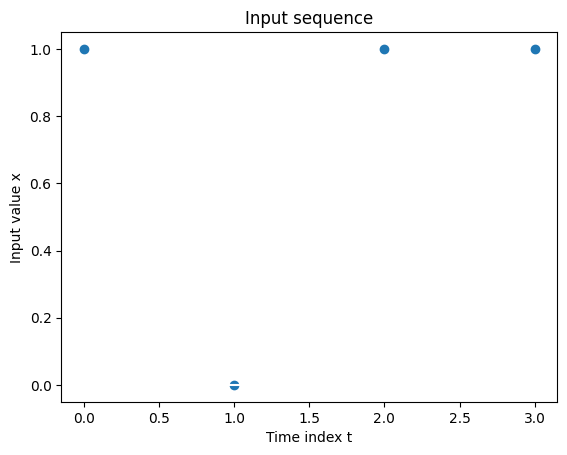

In [35]:
import matplotlib.pyplot as plt

plt.figure()
plt.stem(sequence, use_line_collection=True, linefmt="w", basefmt="w")
plt.xlabel("Time index t")
plt.ylabel("Input value x")
plt.title("Input sequence")
plt.show()

### Model

The model acquires binary data inside a specific temporal window, encodes it by rotating its state vector, and finally the measurement give us a binary outcome following quantum measurement probability. 

#### Information encoding

We use here a single qubit model ($n=1$) to encode our binary input for our temporal window of $\tau = 4$:

In [39]:
from qrobot.models import AngularModel

model = AngularModel(n = 1, tau = tau)

In order to understand how such model works, we can define our event sequence

<img width=500 src="./01_imgs/model_workflow_time_window.png"/>

as follows: 

$$
\Sigma = [1, 0, 1, 1]
$$

As previously said, we associate the binary event $\alpha_i = 0$ ("the cat is dead") with the basis state $\lvert 0 \rangle$ and the binary event $\alpha_i = 1$ ("the cat is asleep") with the basis state $\lvert 1 \rangle$. 

We define the frequency of an event associated with a basis state as:

$$
\tau_{\lvert 0 \rangle}=1 \quad\quad
\tau_{\lvert 1 \rangle}=3
$$

So, the relative frequency of an event associated with a basis state is:

$$
f_{\lvert 0 \rangle}=\frac{1}{4} \quad\quad
f_{\lvert 1 \rangle}=\frac{3}{4}
$$

Now, we encode such information in the qubit in the Bloch sphere representation's angle $\theta$ of a qubit:

<img width=200 src="./01_imgs/bloch_sphere.png"/>

$$
\theta = \pi f_{\lvert 1 \rangle}
$$

Note that we consider here the **AngularModel**, which encodes information directly on the angle of the Bloch sphere representation. Other models are available.

In order to encode such information, we initialize the qubit $\lvert \psi \rangle$ at $\lvert 0 \rangle$ and we use a unitary operator $U$ to apply a fractional rotation of $\pi/\tau$ along the $y$ axis of the Bloch sphere representation.
This operator has to be applied to the qubit $\tau_{\lvert 1 \rangle}$ times for our sequence of events $\Sigma$ (i.e., frequency of "the cat is asleep" events) in order to obtain the desired encoding of $\theta = \pi f_{\lvert 1 \rangle}$.

To apply to a qubit a fractional rotation around the $y$ axis of the Bloch sphere representation we need a $R_y$ gate, which equates to a rotation around the $y$ axis by $\theta$ radians:

<img width=300 align=center src="./01_imgs/rotation_y_gate.png"/>

The correspondent operator is the unitary operator $R_y$:

$$
R_y(\theta) 
=
\exp\left({-i\frac{\theta}{2}Y}\right)
=
\begin{bmatrix}
\cos \frac{\theta}{2}& 
-\sin \frac{\theta}{2}\\
\sin \frac{\theta}{2}& 
\cos \frac{\theta}{2}
\end{bmatrix}.
$$

We can see in our temporal window how the qubit's state vector evolves in the Bloch sphere representation:

<img width=1200 align=center src="./01_imgs/block_sphere_sequence.jpg"/>

With the `quantum-robot` package, we can use the `encode` method of our `model` object to encode event data in the model:

In [40]:
model.clear()  # to re-initialize the model (allows re-runing this cell without double the encoding)

for t in range(0, model.tau):  # loop throug the event sequence
    model.encode(sequence[t], dim=0)

We can see how then our model built a quantum circuit applying the rotation gates when needed:

In [41]:
model.print_circuit()

     ┌─────────┐┌───────┐┌─────────┐┌─────────┐
q_0: ┤ Ry(π/4) ├┤ Ry(0) ├┤ Ry(π/4) ├┤ Ry(π/4) ├
     └─────────┘└───────┘└─────────┘└─────────┘
c: 1/══════════════════════════════════════════
                                               


From the diagram it is possible to notice how we have a rotation for every $\lvert 1 \rangle$ event and a null rotation for every $\lvert 0 \rangle$ event.

Given our input sequece, at the end of the temporal window our model is in the following state:

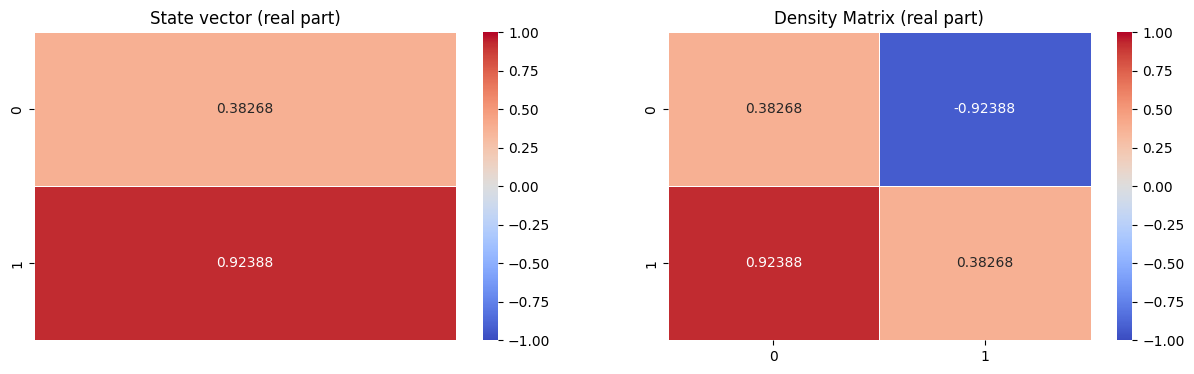

In [42]:
model.plot_state_mat()

#### Information decoding

(...)

### Burst

(...)

### qUnit

(...)

### Connecting the brain

(...)